In [45]:
import os
import pandas as pd

# Define paths for ICU and hospital directories
icu_path = 'icuunzipped'
hosp_path = 'hospunzipped'

# Function to read CSV files and print column names
def print_columns_in_directory(directory_path):
    file_columns = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_csv(file_path, nrows=5)  # Read only a few rows to avoid memory issues
                file_columns[file_name] = list(df.columns)
            except Exception as e:
                file_columns[file_name] = f"Error reading file: {e}"
    return file_columns

# Get column names for ICU and hospital datasets
icu_columns = print_columns_in_directory(icu_path)

hosp_columns = print_columns_in_directory(hosp_path)

print('ICU data')
print(icu_columns)
print('Hosp data')
print(hosp_columns)


ICU data
{'procedureevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime', 'endtime', 'storetime', 'itemid', 'value', 'valueuom', 'location', 'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription', 'patientweight', 'isopenbag', 'continueinnextdept', 'statusdescription', 'ORIGINALAMOUNT', 'ORIGINALRATE'], 'datetimeevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'charttime', 'storetime', 'itemid', 'value', 'valueuom', 'warning'], 'd_items.csv': ['itemid', 'label', 'abbreviation', 'linksto', 'category', 'unitname', 'param_type', 'lownormalvalue', 'highnormalvalue'], 'caregiver.csv': ['caregiver_id'], 'inputevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime', 'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate', 'rateuom', 'orderid', 'linkorderid', 'ordercategoryname', 'secondaryordercategoryname', 'ordercomponenttypedescription', 'ordercategorydescription', 'patientweight'

In [46]:
import os
from ipykernel import get_connection_file

connection_file = get_connection_file()
notebook_path = os.path.dirname(connection_file)

print(notebook_path)

/mmfs1/home/sp3463/.local/share/jupyter/runtime


In [132]:
import pandas as pd

# Load datasets
datetimeevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/datetimeevents.csv')
chartevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/chartevents.csv')
labevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/labevents.csv')
d_items = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/d_items.csv')
d_labitems = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/d_labitems.csv')
admissions = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/admissions.csv')
patients = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/patients.csv')

# Join labevents with d_labitems for labels
labevents_with_metadata = labevents.merge(d_labitems, on='itemid', how='left')

print(labevents_with_metadata)

print("Number of columns in Admissions: ", len(labevents_with_metadata))
# Check for missing values after imputation
missing_values = labevents_with_metadata.isnull().sum()

# Print the results
print("Missing Values before Imputation:")
print(missing_values)

        labevent_id  subject_id     hadm_id  specimen_id  itemid  \
0            172061    10014354  29600294.0      1808066   51277   
1            172062    10014354  29600294.0      1808066   51279   
2            172068    10014354  29600294.0      1808066   52172   
3            172063    10014354  29600294.0      1808066   51301   
4            172050    10014354  29600294.0      1808066   51249   
...             ...         ...         ...          ...     ...   
107722       254700    10021487  28998349.0     78791160   50804   
107723       254702    10021487  28998349.0     78791160   50818   
107724       254707    10021487  28998349.0     78791160   52033   
107725       254706    10021487  28998349.0     78791160   50825   
107726       454886    10038999  27189241.0     13534028   50873   

       order_provider_id            charttime            storetime value  \
0                    NaN  2148-08-16 00:00:00  2148-08-16 01:30:00  15.4   
1                    NaN  2148-

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Filter relevant vitals from chartevents using d_items
relevant_items = d_items[d_items['label'].str.contains('heart rate|blood pressure|temperature', case=False)]
filtered_chartevents = chartevents[chartevents['itemid'].isin(relevant_items['itemid'])]

# Join with metadata for labels
filtered_chartevents = filtered_chartevents.merge(d_items[['itemid', 'label']], on='itemid', how='left')

# Join with patient and admission details
chartevents_with_context = filtered_chartevents.merge(admissions, on=['subject_id', 'hadm_id'], how='left')
chartevents_with_context = chartevents_with_context.merge(patients, on='subject_id', how='left')

# Select relevant columns
vitals_data = chartevents_with_context[['subject_id', 'hadm_id', 'label', 'valuenum', 'valueuom', 'gender', 'anchor_age', 'admission_type']]

# Handle missing values carefully
# Drop columns with more than 50% missing data
missing_threshold = 0.5
missing_percentage = vitals_data.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index
print("Columns to drop: ", columns_to_drop)
vitals_data = vitals_data.drop(columns=columns_to_drop)

missing_values = vitals_data.isnull().sum()

# Print the results
print("Length of dataset: ", len(vitals_data))
print("Missing Values before Imputation:")
print(missing_values)

Columns to drop:  Index([], dtype='object')
Length of dataset:  70413
Missing Values before Imputation:
subject_id           0
hadm_id              0
label                0
valuenum          5816
valueuom          5816
gender               0
anchor_age           0
admission_type       0
dtype: int64


In [146]:
# Impute missing values if the number of records with missing values is less than 10% of the total dataset length
missing_count = vitals_data.isnull().sum()
rows_threshold = 0.1 * len(vitals_data)
columns_to_impute = missing_count[missing_count > rows_threshold].index
print("Columns to impute: ", columns_to_impute)

if len(columns_to_impute)!=0:
    imputer = SimpleImputer(strategy='mean')
    vitals_data[columns_to_impute] = imputer.fit_transform(vitals_data[columns_to_impute])

missing_values = vitals_data.isnull().sum()

# Print the results
print("Missing Values after Imputation:")
print(missing_values)

print(vitals_data)
# Drop rows with remaining missing values
vitals_data = vitals_data.dropna()

print(vitals_data)

Columns to impute:  Index([], dtype='object')
Missing Values after Imputation:
subject_id           0
hadm_id              0
label                0
valuenum          5816
valueuom          5816
gender               0
anchor_age           0
admission_type       0
dtype: int64
       subject_id   hadm_id                                  label  valuenum  \
0        10005817  20626031                 Heart Rate Alarm - Low      55.0   
1        10005817  20626031                Heart rate Alarm - High     120.0   
2        10005817  20626031      Arterial Blood Pressure diastolic      37.0   
3        10005817  20626031                    Temperature Celsius      37.0   
4        10005817  20626031   Arterial Blood Pressure Alarm - High     140.0   
...           ...       ...                                    ...       ...   
70408    10019003  29279905                             Heart Rate      99.0   
70409    10019003  29279905                 Temperature Fahrenheit      97.8   
7041

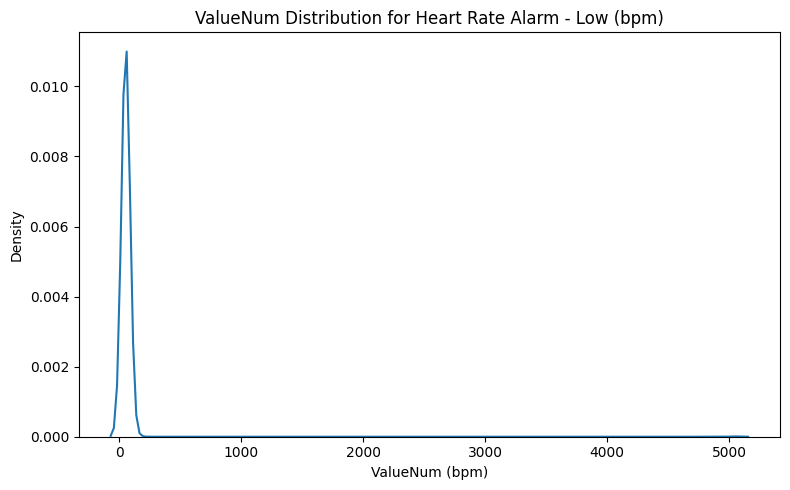

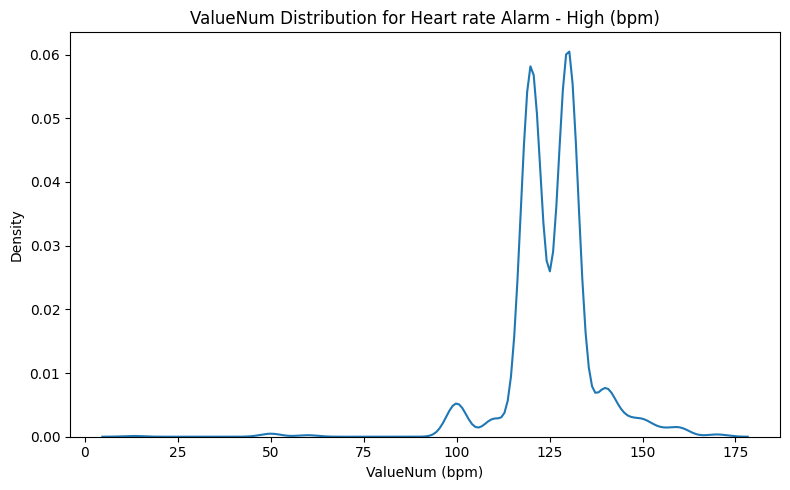

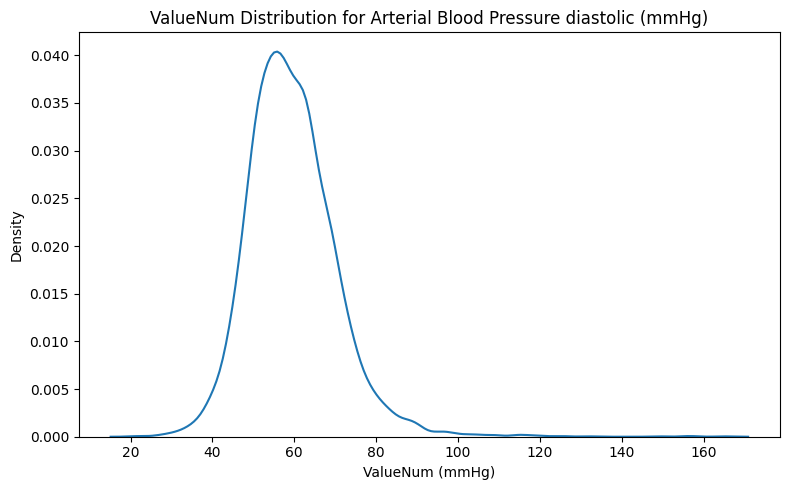

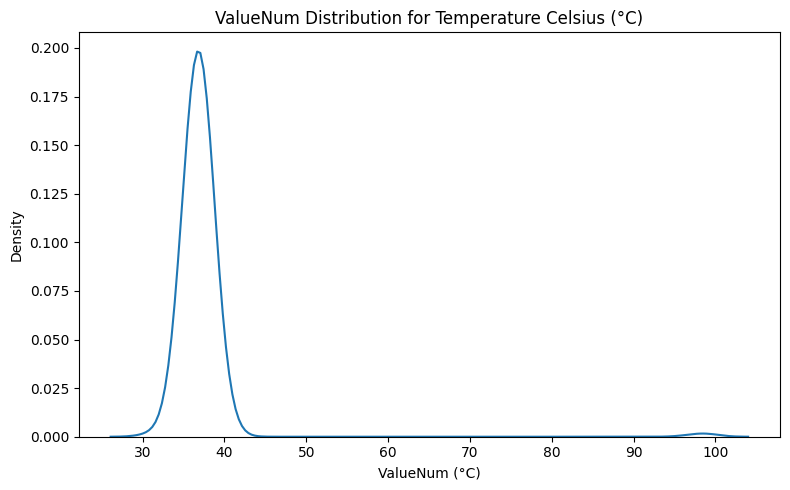

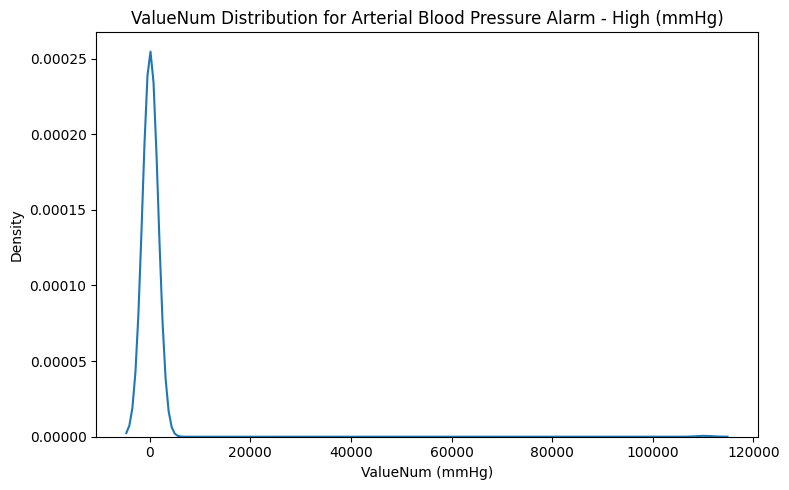

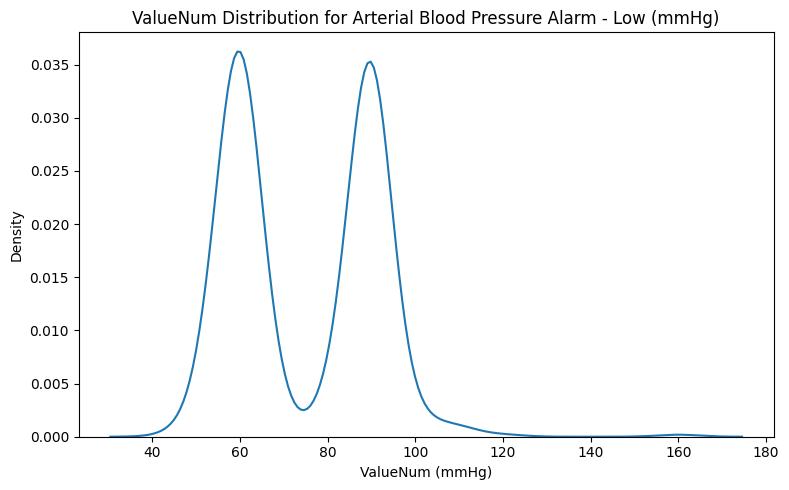

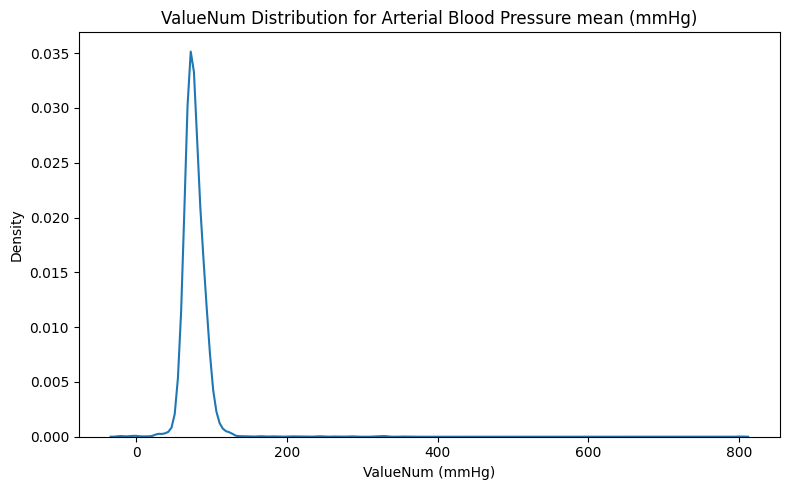

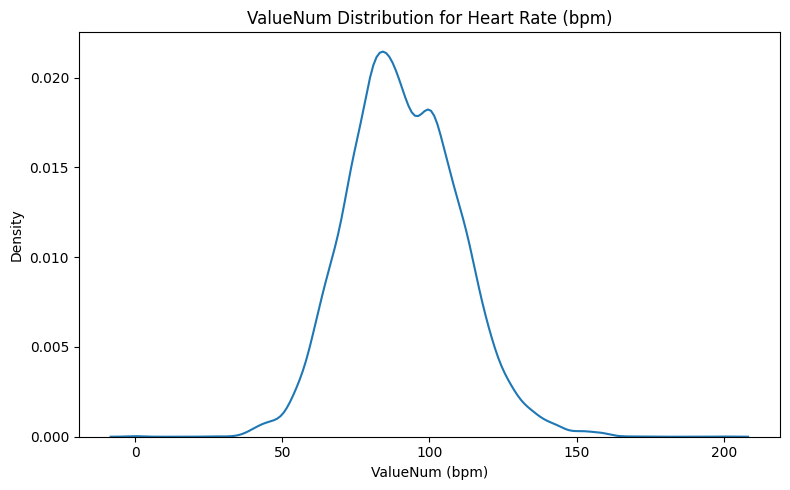

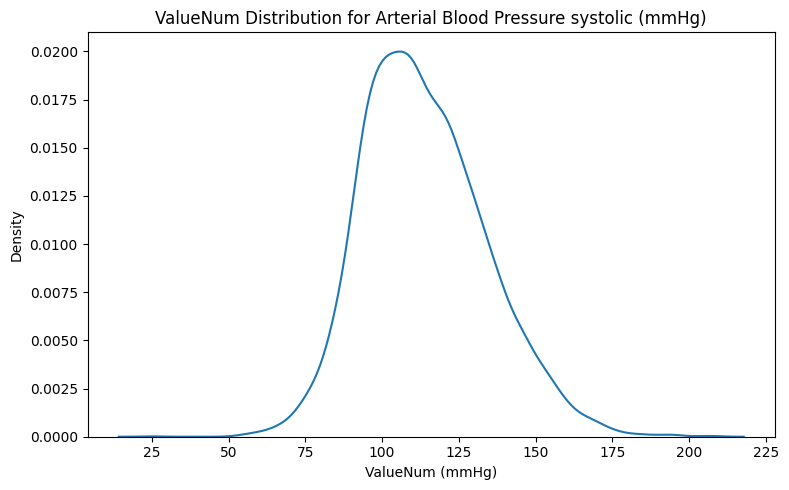

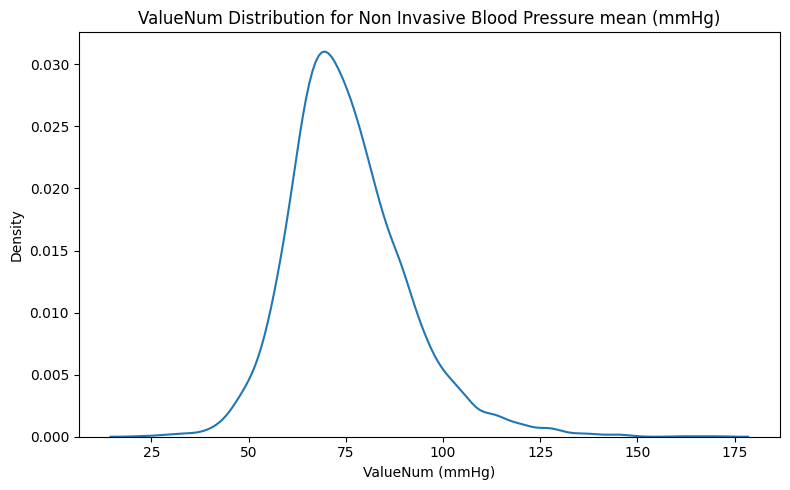

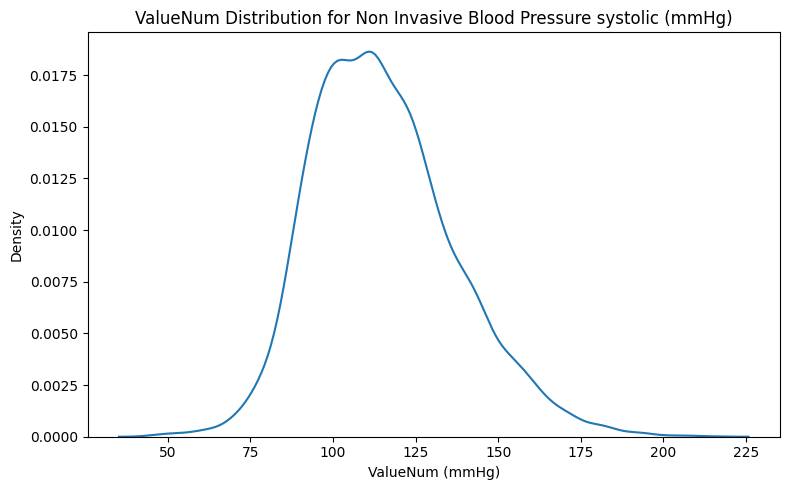

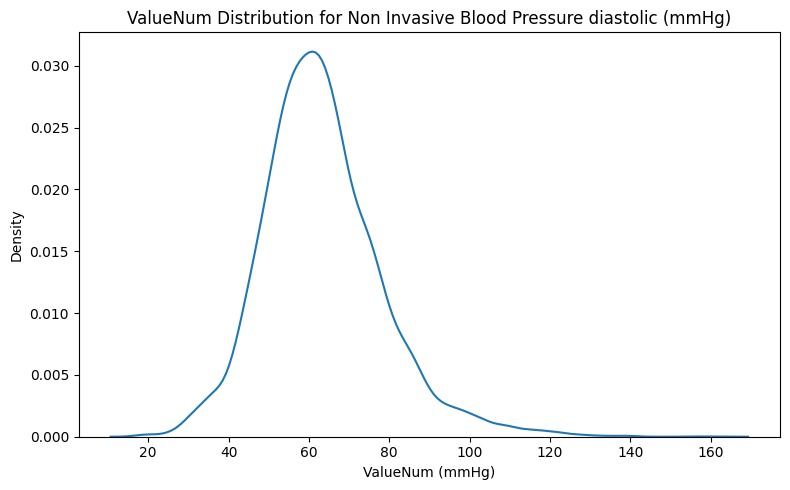

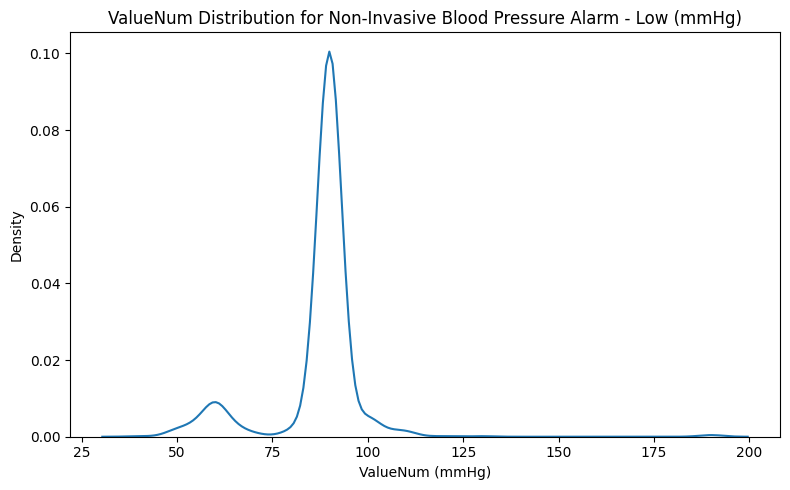

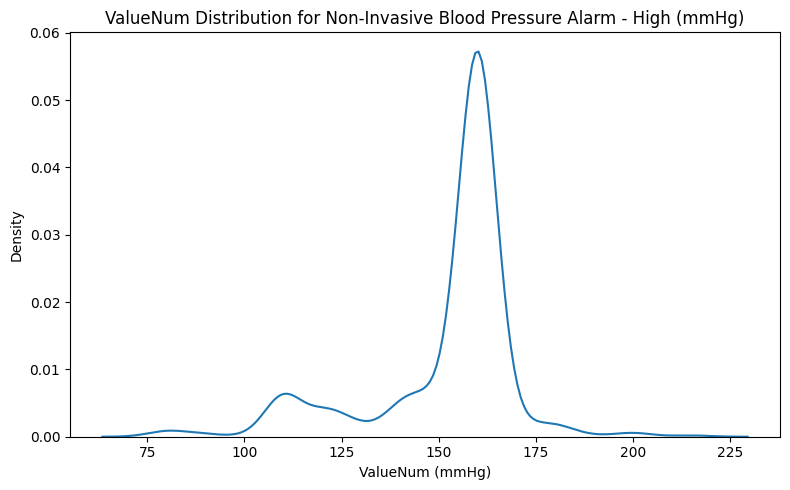

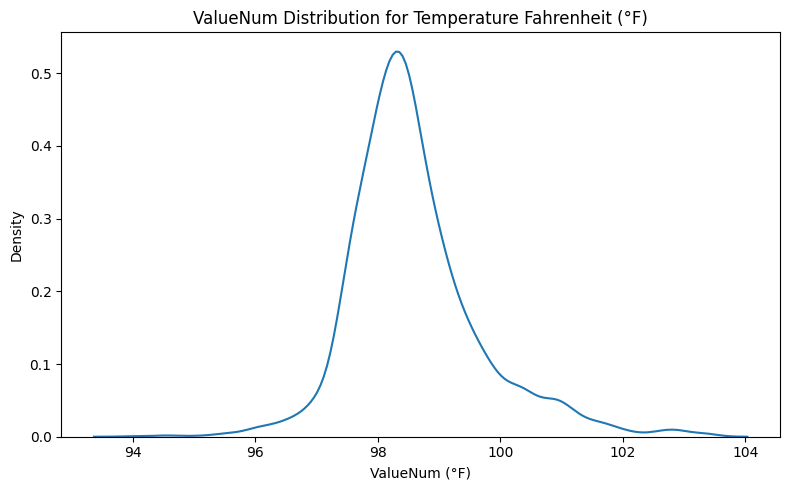

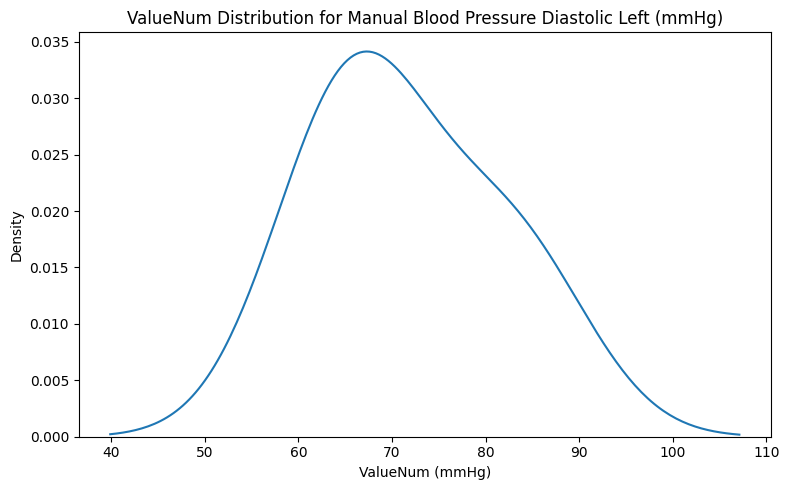

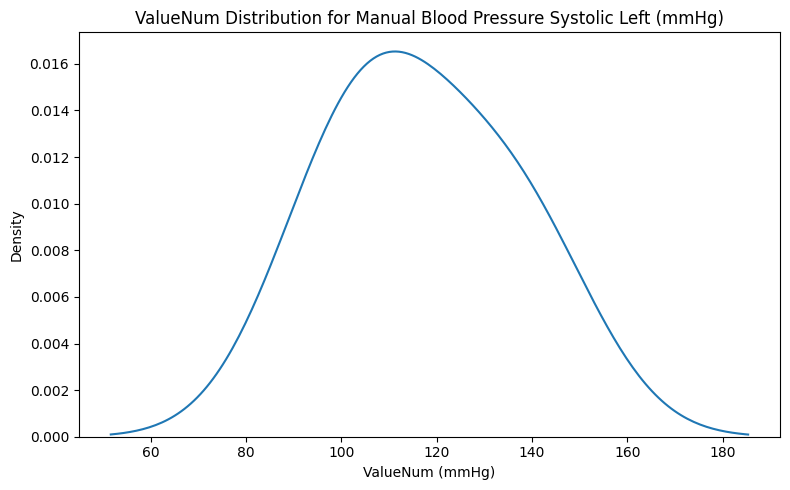

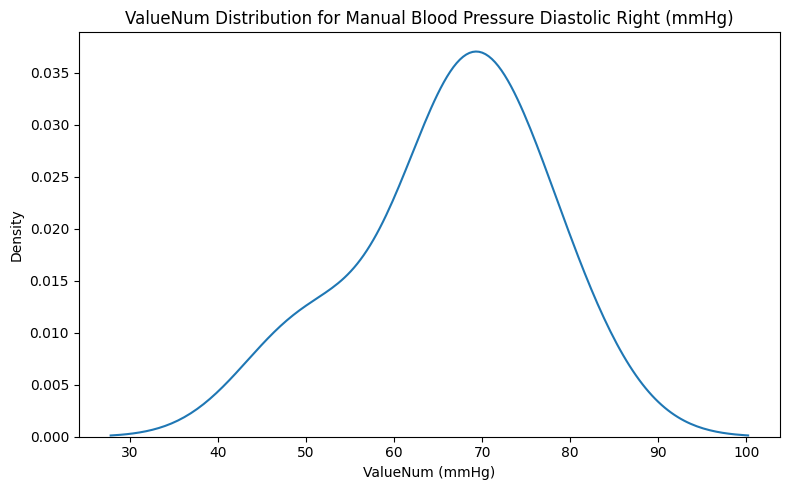

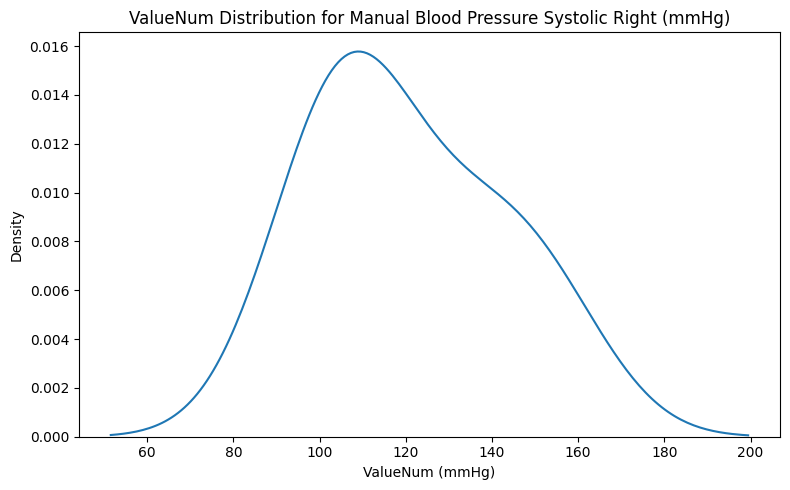

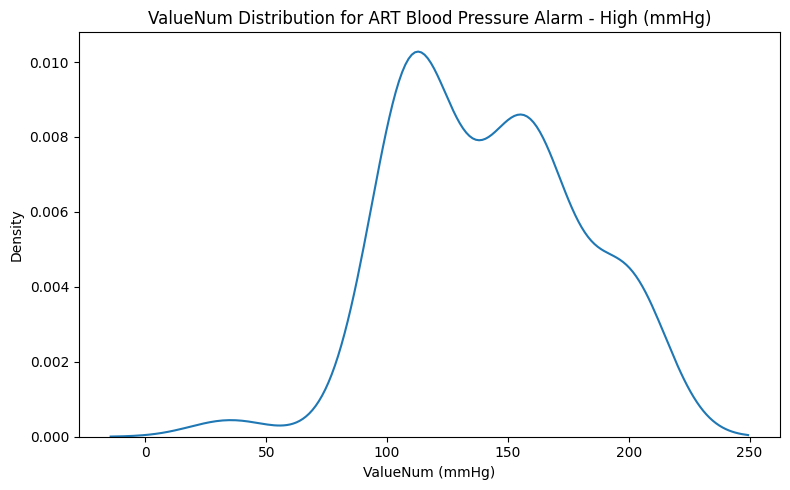

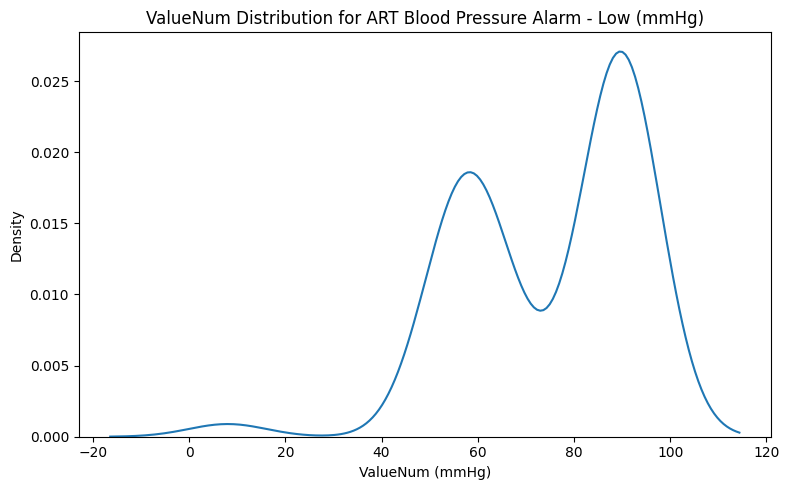

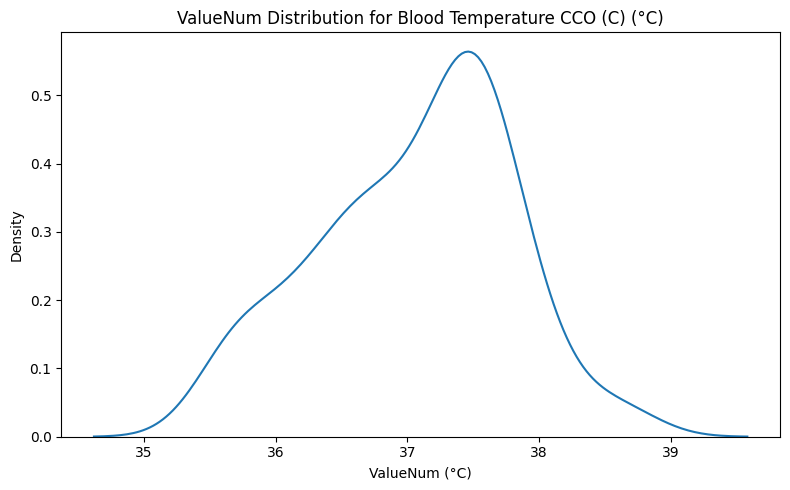

In [147]:
for label in vitals_data['label'].unique():
    subset = vitals_data[vitals_data['label'] == label]
    plt.figure(figsize=(8, 5))
    sns.kdeplot(subset['valuenum'])
    valueuom = subset['valueuom'].iloc[0] if 'valueuom' in subset.columns and not subset['valueuom'].isnull().all() else 'N/A'
    plt.title(f'ValueNum Distribution for {label} ({valueuom})')
    plt.xlabel(f'ValueNum ({valueuom})')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

In [148]:
print(vitals_data['gender'].unique())

['M' 'F']


In [149]:
# ----------------------
# Feature Transformations
# ----------------------

# One-Hot Encoding (if applicable)
# In this case, we will apply one-hot encoding to categorical columns like 'label', 'gender', 'admission_type'
# This step is only necessary if categorical data is present and cannot be used directly in its original form
#categorical_columns = ['label', 'gender', 'admission_type']
#categorical_columns = ['gender']
#existing_categorical_columns = [col for col in categorical_columns if col in vitals_data.columns]

#if existing_categorical_columns:
#    vitals_data = pd.get_dummies(vitals_data, columns=existing_categorical_columns, drop_first=True)

# Label Encoding for categorical columns
#from sklearn.preprocessing import LabelEncoder

#categorical_columns = ['gender']
#label_encoder = LabelEncoder()

#for col in categorical_columns:
#    if col in vitals_data.columns:
#        vitals_data[col] = label_encoder.fit_transform(vitals_data[col])

vitals_data['gender'] = vitals_data['gender'].map({'M': 1, 'F': 0})

In [150]:
print(vitals_data)

       subject_id   hadm_id                                  label  valuenum  \
0        10005817  20626031                 Heart Rate Alarm - Low      55.0   
1        10005817  20626031                Heart rate Alarm - High     120.0   
2        10005817  20626031      Arterial Blood Pressure diastolic      37.0   
3        10005817  20626031                    Temperature Celsius      37.0   
4        10005817  20626031   Arterial Blood Pressure Alarm - High     140.0   
...           ...       ...                                    ...       ...   
70406    10019003  29279905       Non Invasive Blood Pressure mean      77.0   
70408    10019003  29279905                             Heart Rate      99.0   
70409    10019003  29279905                 Temperature Fahrenheit      97.8   
70410    10019003  29279905  Non Invasive Blood Pressure diastolic      62.0   
70411    10019003  29279905   Non Invasive Blood Pressure systolic     118.0   

      valueuom  gender  anchor_age admi

In [131]:
# ----------------------
# Feature Transformations
# ----------------------

# Pivot the data so that each label becomes a separate column
vitals_pivot = vitals_data.pivot_table(index=['subject_id', 'hadm_id'], columns='label', values='valuenum', aggfunc='mean').reset_index()

# Merge with demographic features (gender, anchor_age, admission_type)
demographics = vitals_data[['subject_id', 'hadm_id', 'gender', 'anchor_age', 'admission_type']].drop_duplicates()
vitals_data = pd.merge(vitals_pivot, demographics, on=['subject_id', 'hadm_id'], how='left')

print(vitals_data)

missing_values = vitals_data.isnull().sum()

# Print the results
print("Missing Values before Imputation:")
print(missing_values)

KeyError: 'valuenum'

In [151]:
vitals_data.drop('valueom', axis=1, inplace=True)

KeyError: "['valueom'] not found in axis"

In [152]:
# Pivot the data so that each label becomes a separate column
vitals_pivot = vitals_data.pivot_table(index=['subject_id', 'hadm_id'], columns='label', values='valuenum', aggfunc='mean').reset_index()

# Merge with demographic features (gender, anchor_age, admission_type)
demographics = vitals_data[['subject_id', 'hadm_id', 'gender', 'anchor_age', 'admission_type']].drop_duplicates()
vitals_data = pd.merge(vitals_pivot, demographics, on=['subject_id', 'hadm_id'], how='left')

# Label Encoding for categorical columns (admission_type)
label_encoder = LabelEncoder()
vitals_data['admission_type'] = label_encoder.fit_transform(vitals_data['admission_type'])
vitals_data['gender'] = label_encoder.fit_transform(vitals_data['gender'])

# Handle missing values after pivoting using median imputation
imputer = SimpleImputer(strategy='median')
vitals_data.iloc[:, 2:] = imputer.fit_transform(vitals_data.iloc[:, 2:])

# Convert gender to 0s and 1s
#vitals_data['gender'] = vitals_data['gender'].map({'M': 1, 'F': 0})

In [153]:
vitals_data.dtypes

subject_id                                    int64
hadm_id                                       int64
ART Blood Pressure Alarm - High             float64
ART Blood Pressure Alarm - Low              float64
Arterial Blood Pressure Alarm - High        float64
Arterial Blood Pressure Alarm - Low         float64
Arterial Blood Pressure diastolic           float64
Arterial Blood Pressure mean                float64
Arterial Blood Pressure systolic            float64
Blood Temperature CCO (C)                   float64
Heart Rate                                  float64
Heart Rate Alarm - Low                      float64
Heart rate Alarm - High                     float64
Manual Blood Pressure Diastolic Left        float64
Manual Blood Pressure Diastolic Right       float64
Manual Blood Pressure Systolic Left         float64
Manual Blood Pressure Systolic Right        float64
Non Invasive Blood Pressure diastolic       float64
Non Invasive Blood Pressure mean            float64
Non Invasive

In [155]:
vitals_data.dtypes

subject_id                                    int64
hadm_id                                       int64
ART Blood Pressure Alarm - High             float64
ART Blood Pressure Alarm - Low              float64
Arterial Blood Pressure Alarm - High        float64
Arterial Blood Pressure Alarm - Low         float64
Arterial Blood Pressure diastolic           float64
Arterial Blood Pressure mean                float64
Arterial Blood Pressure systolic            float64
Blood Temperature CCO (C)                   float64
Heart Rate                                  float64
Heart Rate Alarm - Low                      float64
Heart rate Alarm - High                     float64
Manual Blood Pressure Diastolic Left        float64
Manual Blood Pressure Diastolic Right       float64
Manual Blood Pressure Systolic Left         float64
Manual Blood Pressure Systolic Right        float64
Non Invasive Blood Pressure diastolic       float64
Non Invasive Blood Pressure mean            float64
Non Invasive

In [156]:
vitals_data

,subject_id,hadm_id,ART Blood Pressure Alarm - High,ART Blood Pressure Alarm - Low,Arterial Blood Pressure Alarm - High,Arterial Blood Pressure Alarm - Low,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Blood Temperature CCO (C),...,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Non-Invasive Blood Pressure Alarm - High,Non-Invasive Blood Pressure Alarm - Low,Temperature Celsius,Temperature Fahrenheit,gender,anchor_age,admission_type
0,10000032,29079034,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,54.100000,62.300000,88.900000,160.000000,82.500000,36.426923,98.966667,0,52,2
1,10001217,24597018,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,81.333333,93.500000,136.296296,150.000000,90.000000,36.426923,99.066667,0,55,2
2,10001217,27703517,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,73.478261,83.217391,115.869565,150.000000,90.000000,36.426923,98.133333,0,55,0
3,10001725,25563031,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,61.187500,70.062500,100.406250,160.000000,90.000000,36.426923,97.900000,0,46,2
4,10002428,20321825,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,51.978723,63.127660,100.000000,160.000000,90.000000,36.426923,98.453846,0,80,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,10039708,24928679,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,62.722222,76.722222,108.833333,160.000000,90.000000,36.426923,98.444444,0,46,3
124,10039708,28258130,180.0,90.0,112.5,65.909091,62.060403,76.870536,95.460850,37.080823,...,64.048000,70.374502,92.224000,126.111111,72.222222,36.426923,97.437594,0,46,2
125,10039831,26924951,137.5,77.5,160.0,93.333333,55.918919,77.621622,117.891892,37.080823,...,62.000000,75.956989,133.000000,160.000000,110.000000,36.426923,99.808333,0,57,4
126,10039997,24294180,160.0,90.0,145.0,113.333333,65.642857,91.142857,141.250000,37.080823,...,85.000000,100.375000,148.125000,160.000000,90.000000,36.426923,98.500000,0,67,4


In [66]:
#for col in vitals_data.select_dtypes(include='bool').columns:
#    vitals_data[col] = vitals_data[col].astype(int)

In [163]:
vitals_data.dtypes

subject_id                                  float64
hadm_id                                     float64
ART Blood Pressure Alarm - High             float64
ART Blood Pressure Alarm - Low              float64
Arterial Blood Pressure Alarm - High        float64
Arterial Blood Pressure Alarm - Low         float64
Arterial Blood Pressure diastolic           float64
Arterial Blood Pressure mean                float64
Arterial Blood Pressure systolic            float64
Blood Temperature CCO (C)                   float64
Heart Rate                                  float64
Heart Rate Alarm - Low                      float64
Heart rate Alarm - High                     float64
Manual Blood Pressure Diastolic Left        float64
Manual Blood Pressure Diastolic Right       float64
Manual Blood Pressure Systolic Left         float64
Manual Blood Pressure Systolic Right        float64
Non Invasive Blood Pressure diastolic       float64
Non Invasive Blood Pressure mean            float64
Non Invasive

In [159]:
# Scale numerical features
scaler = StandardScaler()
numerical_columns = vitals_data.select_dtypes(include=['float64', 'int64']).columns
vitals_data[numerical_columns] = scaler.fit_transform(vitals_data[numerical_columns])

print(vitals_data)

     subject_id   hadm_id  ART Blood Pressure Alarm - High  \
0     -1.700432  1.326466                         0.037075   
1     -1.592244 -0.186975                         0.037075   
2     -1.592244  0.861996                         0.037075   
3     -1.545865  0.139219                         0.037075   
4     -1.481683 -1.630578                         0.037075   
..          ...       ...                              ...   
123    1.921880 -0.074983                         0.037075   
124    1.921880  1.049272                         3.196653   
125    1.933110  0.599098                         0.037075   
126    1.948265 -0.289234                         1.709792   
127    1.950822  0.960849                         0.037075   

     ART Blood Pressure Alarm - Low  Arterial Blood Pressure Alarm - High  \
0                          0.078142                             -0.088519   
1                          0.078142                             -0.088519   
2                       

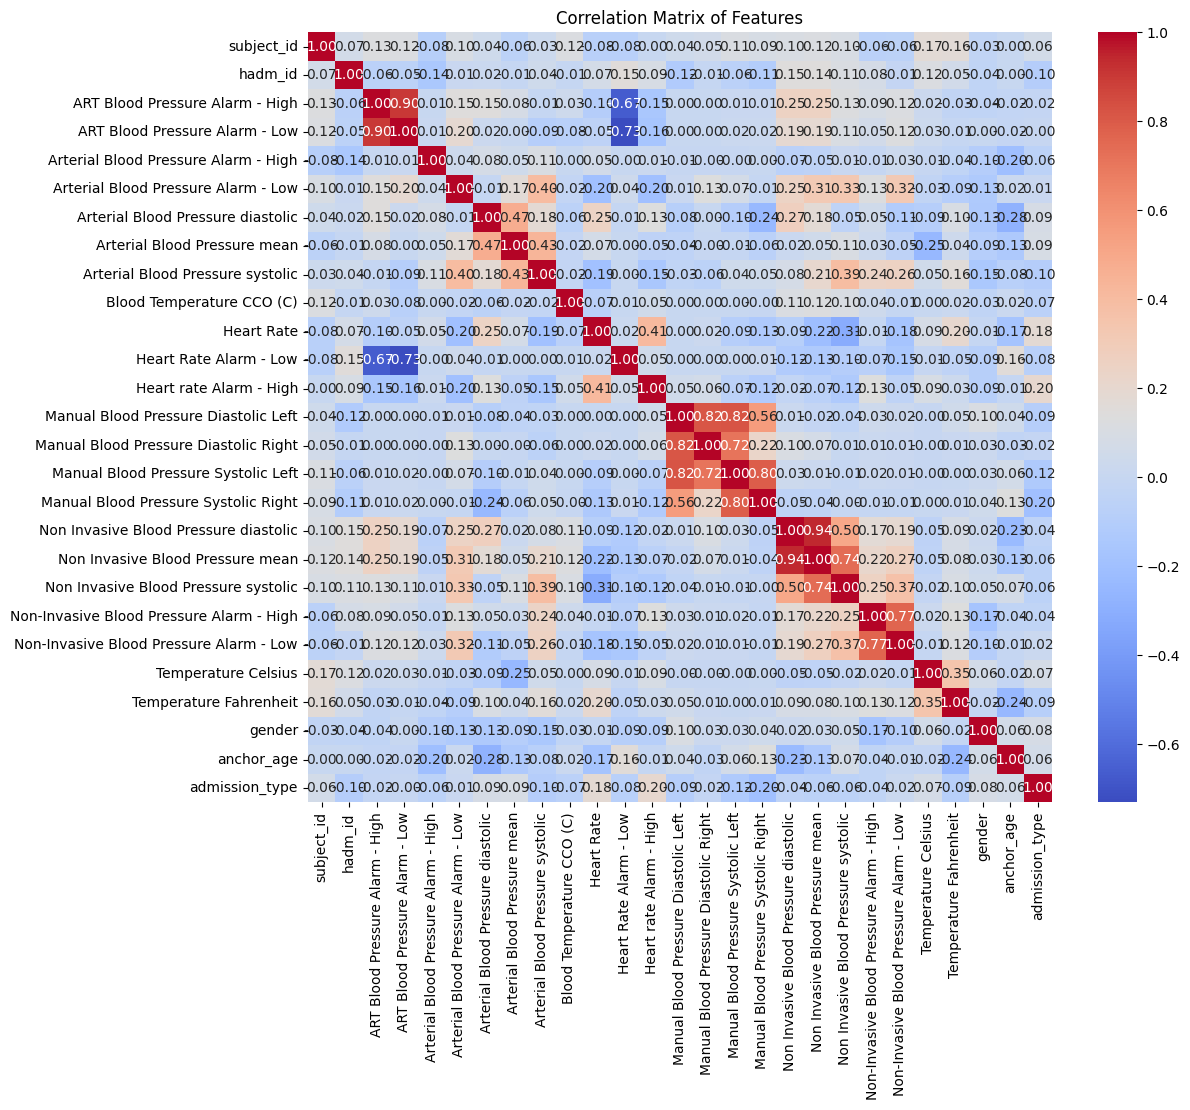

In [160]:
# Correlation Matrix of Features
correlation_matrix = vitals_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

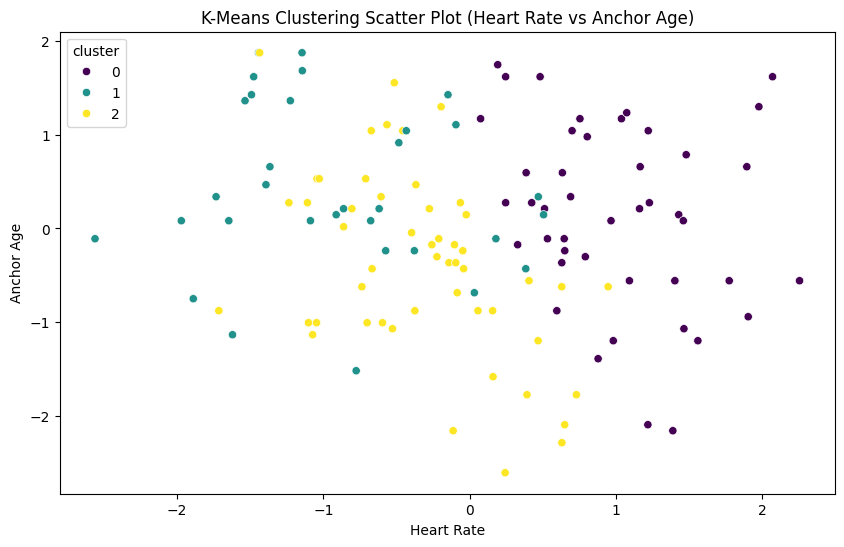

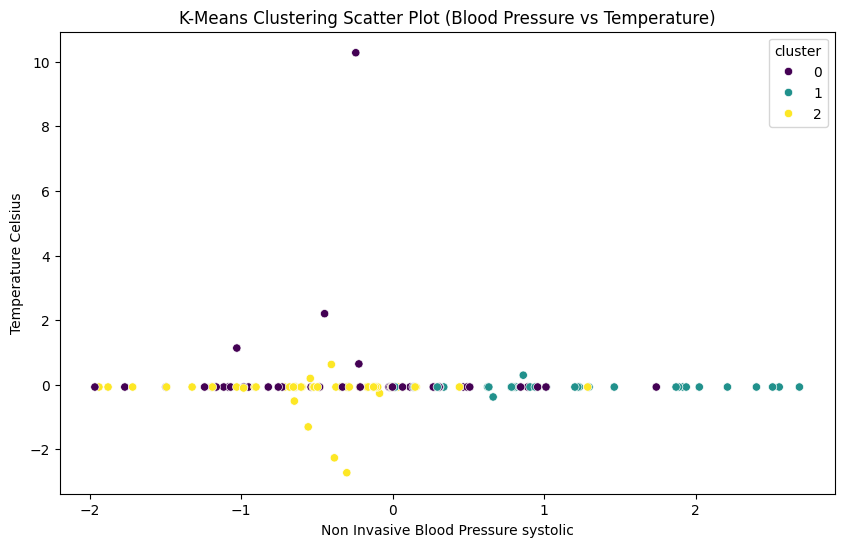

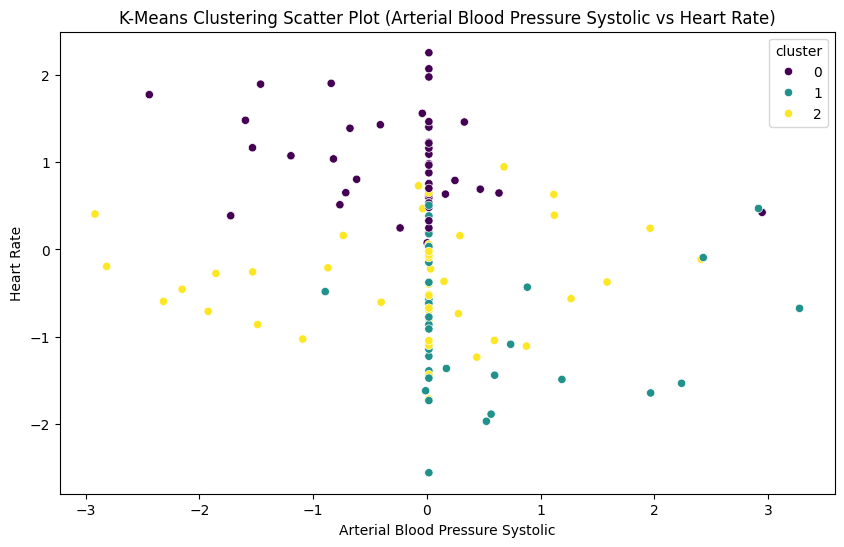

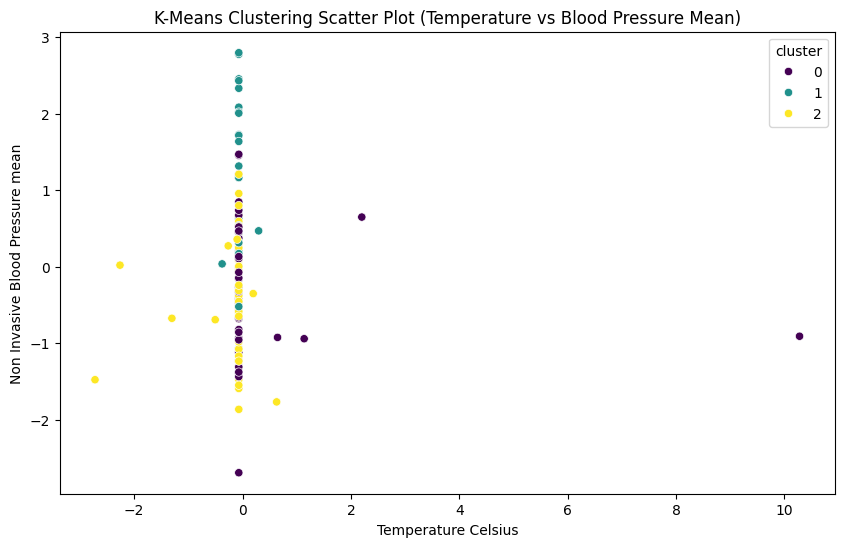

In [164]:
# Perform K-Means clustering
# Reduce dimensionality by selecting relevant features for clustering
selected_features = ['anchor_age', 'Heart Rate', 'Non Invasive Blood Pressure systolic', 'Temperature Celsius']
kmeans = KMeans(n_clusters=3, random_state=42)
vitals_data['cluster'] = kmeans.fit_predict(vitals_data[selected_features])

# Visualize K-Means Clustering using scatter plots for relevant feature pairs
# Scatter Plot 1: Heart Rate vs Anchor Age
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Heart Rate', y='anchor_age', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Heart Rate vs Anchor Age)')
plt.xlabel('Heart Rate')
plt.ylabel('Anchor Age')
plt.show()

# Scatter Plot 2: Non Invasive Blood Pressure systolic vs Temperature Celsius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Non Invasive Blood Pressure systolic', y='Temperature Celsius', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Blood Pressure vs Temperature)')
plt.xlabel('Non Invasive Blood Pressure systolic')
plt.ylabel('Temperature Celsius')
plt.show()

# Scatter Plot 3: Arterial Blood Pressure Systolic vs Heart Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Arterial Blood Pressure systolic', y='Heart Rate', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Arterial Blood Pressure Systolic vs Heart Rate)')
plt.xlabel('Arterial Blood Pressure Systolic')
plt.ylabel('Heart Rate')
plt.show()

# Scatter Plot 4: Temperature Celsius vs Non Invasive Blood Pressure mean
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Temperature Celsius', y='Non Invasive Blood Pressure mean', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Temperature vs Blood Pressure Mean)')
plt.xlabel('Temperature Celsius')
plt.ylabel('Non Invasive Blood Pressure mean')
plt.show()

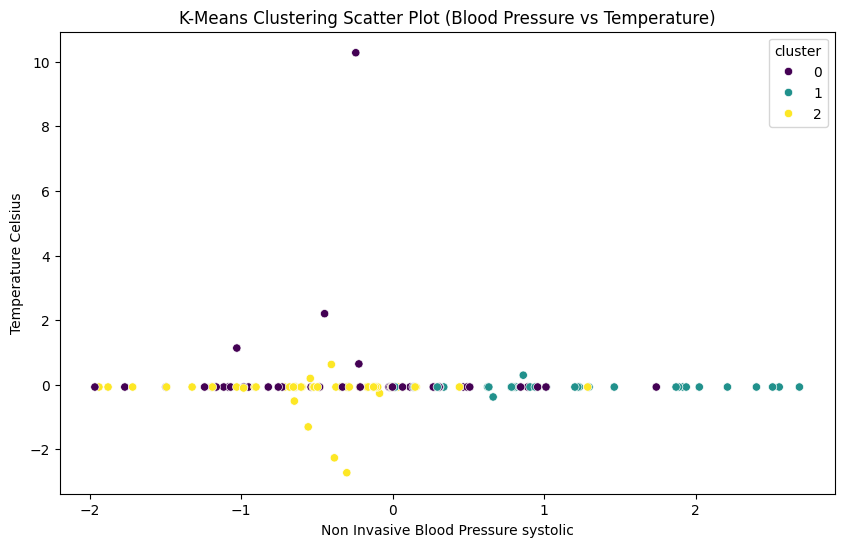

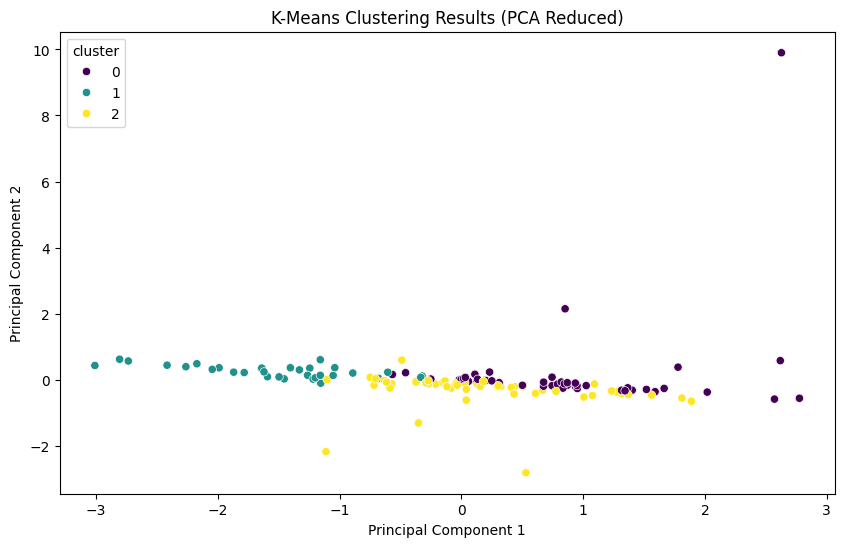

In [166]:
# Scatter Plot 2: Non Invasive Blood Pressure systolic vs Temperature Celsius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Non Invasive Blood Pressure systolic', y='Temperature Celsius', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Blood Pressure vs Temperature)')
plt.xlabel('Non Invasive Blood Pressure systolic')
plt.ylabel('Temperature Celsius')
plt.show()

# Visualize Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vitals_data[selected_features])
vitals_data['pca1'] = principal_components[:, 0]
vitals_data['pca2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Results (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()